In [1]:
%%capture
!pip install arviz
!pip install pymc3
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm
import seaborn as sns
from pymc3 import math

from scipy import stats

In [3]:
#read in the files
with open('c_no_punish.npy', 'rb') as f:
    c_no_punish = np.load(f)

with open('c_punish.npy', 'rb') as f:
    c_punish = np.load(f)

with open('c.npy', 'rb') as f:
    c = np.load(f)

with open('Ga_no_punish.npy', 'rb') as f:
    Ga_no_punish = np.load(f)

with open('Ga_punish.npy', 'rb') as f:
    Ga_punish = np.load(f)

with open('Ga.npy', 'rb') as f:
    Ga = np.load(f)

with open('Gc_no_punish.npy', 'rb') as f:
    Gc_no_punish = np.load(f)

with open('Gc_punish.npy', 'rb') as f:
    Gc_punish = np.load(f)

with open('Gc.npy', 'rb') as f:
    Gc = np.load(f)

with open('Gini.npy', 'rb') as f:
    Gini = np.load(f)

with open('c_choice_index.npy', 'rb') as f:
    c_choice_index = np.load(f)


In [4]:
groupSize = 4 # n people in groups
ntrials = 10 #ntrials
pi = 1.4
ntokens = 20 # max value to contribute
ngroups = 244
vals = np.arange(0,21,1) # possible values to contribute - from 0 to 20 tokens

In [5]:
df = []
for person in range(0,4):
    for trial in range (0,10):
        for group in range (0,244):
            df.append([person, trial, group, c[person, trial, group,0]])
            
df = pd.DataFrame(df, columns=['person', 'trial', 'group', 'value'])

In [6]:
gini_df = pd.DataFrame(Gini,  columns=['gini'])

In [7]:
gini_df['group'] = gini_df.index

In [8]:
data = df.merge(gini_df, on='group', how='left')

In [9]:
idx = pd.Categorical(data.person).codes
groupx = pd.Categorical(data.group).codes
trialx = pd.Categorical(data.trial).codes

In [ ]:
#decay model

with pm.Model() as decay_model:
    beta0_c0 = pm.HalfNormal('beta0_c0', sigma =1)

    betaGini_c0 = pm.Normal(' betaGini_c0', mu = 0, sigma = 1)

    
    beta0_gamma = pm.HalfNormal('beta0_gamma', sigma = 1)

    betaGini_gamma = pm.Normal('betaGini_gamma', mu = 0, sigma = 1)


    sigma_c = pm.Gamma('sigma_c', alpha = 1, beta = 1, shape = (4,244))
    c_0 = pm.Deterministic('c_0', beta0_c0 + betaGini_c0 * Gini[groupx] )
    gamma = pm.Deterministic('gamma', beta0_gamma+ (betaGini_gamma* Gini[groupx]))
    mu_c = pm.Deterministic('mu_c',c_0[groupx] * pm.math.exp(-gamma[groupx] * data.trial))
    c_person = pm.Normal('c_person', mu = mu_c[groupx], sigma = sigma_c[idx, groupx], observed = data.value, shape = (4, 244))
    trace = pm.sample(return_inferencedata = True, chains=1, random_seed = 456)  

In [14]:
import warnings
warnings.filterwarnings('ignore')
az.summary(trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
betaGini_c0,-1.740000e-01,0.015,-0.203,-1.470000e-01,0.001,0.000,631.0,734.0,NaN
betaGini_gamma,1.150000e-01,0.930,-1.524,1.851000e+00,0.035,0.032,692.0,434.0,NaN
beta0_c0,1.334300e+01,0.505,12.440,1.428800e+01,0.020,0.014,663.0,796.0,NaN
beta0_gamma,7.910000e-01,0.604,0.002,1.917000e+00,0.022,0.016,448.0,311.0,NaN
"sigma_c[0,0]",7.493000e+00,1.267,5.254,9.921000e+00,0.041,0.029,985.0,678.0,NaN
...,...,...,...,...,...,...,...,...,...
mu_c[9755],1.477999e+236,inf,0.000,8.148707e+160,NaN,NaN,693.0,412.0,NaN
mu_c[9756],1.477999e+236,inf,0.000,8.148707e+160,NaN,NaN,693.0,412.0,NaN
mu_c[9757],1.477999e+236,inf,0.000,8.148707e+160,NaN,NaN,693.0,412.0,NaN
mu_c[9758],1.477999e+236,inf,0.000,8.148707e+160,NaN,NaN,693.0,412.0,NaN


In [15]:
az.summary(trace, var_names = [' betaGini_c0', 'betaGini_gamma', 'beta0_c0', 'beta0_gamma', 'sigma_c', 'gamma'])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
betaGini_c0,-0.174,0.015,-0.203,-0.147,0.001,0.000,631.0,734.0,NaN
betaGini_gamma,0.115,0.930,-1.524,1.851,0.035,0.032,692.0,434.0,NaN
beta0_c0,13.343,0.505,12.440,14.288,0.020,0.014,663.0,796.0,NaN
beta0_gamma,0.791,0.604,0.002,1.917,0.022,0.016,448.0,311.0,NaN
"sigma_c[0,0]",7.493,1.267,5.254,9.921,0.041,0.029,985.0,678.0,NaN
...,...,...,...,...,...,...,...,...,...
gamma[9755],4.567,30.403,-51.332,59.336,1.132,1.070,694.0,412.0,NaN
gamma[9756],4.567,30.403,-51.332,59.336,1.132,1.070,694.0,412.0,NaN
gamma[9757],4.567,30.403,-51.332,59.336,1.132,1.070,694.0,412.0,NaN
gamma[9758],4.567,30.403,-51.332,59.336,1.132,1.070,694.0,412.0,NaN


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f6ef24ccc90>,
      dtype=object)

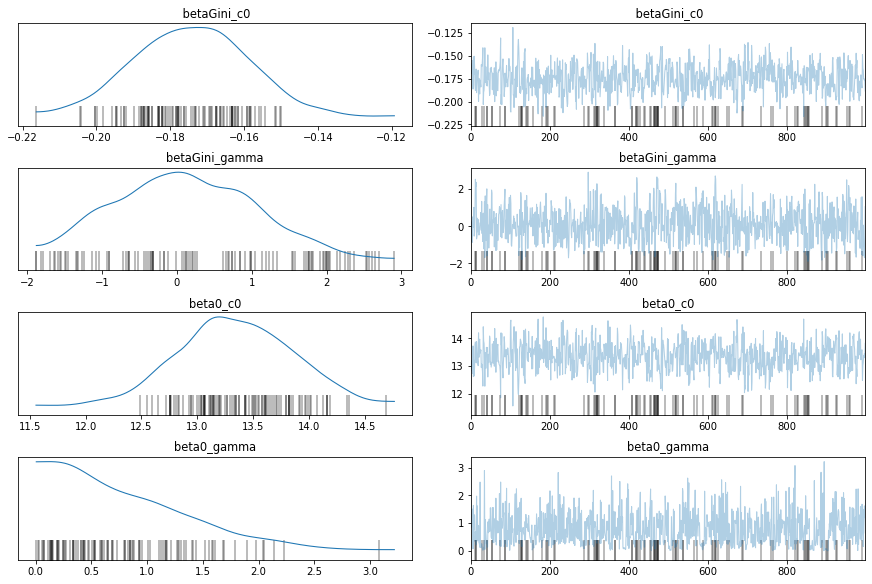

In [16]:
az.plot_trace(trace, var_names = [' betaGini_c0', 'betaGini_gamma', 'beta0_c0', 'beta0_gamma'])

In [17]:
with decay_model:
    ppc = pm.sample_posterior_predictive(
        trace, random_seed=678)

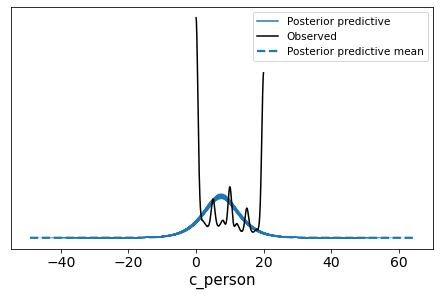

In [18]:
az.plot_ppc(az.from_pymc3(posterior_predictive=ppc, model=decay_model));

In [ ]:
#THE CC MODEL

In [10]:
#standardise Gini score for analysis - we need to do this because model is more complex and won't converge otherwise
Gini_unst = Gini
Gini = (Gini - np.average(Gini)) / (np.std(Gini))

In [11]:
import theano.tensor as tsr #found code on stackoverflow

def probit_phi(x):
    """ Probit transform assuming 0 mean and 1 sd """
    mu = 0
    sd = 1
    return 0.5 * (1 + tsr.erf((x - mu) / (sd * tsr.sqrt(2))))

In [12]:
Gini_mat = np.array([Gini,Gini,Gini,Gini])

Trials_mat = np.array([0,1,2,3,4,5,6,7,8,9])
Trials_mat = np.array([Trials_mat,Trials_mat,Trials_mat,Trials_mat]).T
Trials_mat = Trials_mat[:,:,None]
Trials_mat.shape

values = np.array([vals,vals,vals,vals]).T
values = values[:,:,None]


In [ ]:
# NOTE: the following model should be conceptually identical to the original
# it appears, however, that at some point in the estimate some parameter gets extremely small
# or extremely large and a division by 0 occurs. A better transform should scale parameters up
# so as to avoid this. We are not exactly sure where to put our hands tho.

In [13]:
from pymc3.math import switch, lt


with pm.Model() as CC_Gini:
    #beta0_pbeta = 1
    beta0_pbeta = pm.Normal('beta0_pbeta', mu = 0, sigma = 1)
    #betaGini_pbeta = 1
    betaGini_pbeta = pm.Normal('betaGini_pbeta', mu = 0, sigma = 1)
    
    #------------------------- Individual regression priors -------------------------------------------
    mu_pbeta_probit = pm.Deterministic('mu_pbeta_probit', beta0_pbeta + (betaGini_pbeta*Gini_mat))
    #mu_pbeta_probit = 1
    sigma_pbeta = pm.Uniform('sigma_pbeta', 1, 100, shape = (4, 244)) #concentration parameter for reparameterised beta distribution
    #sigma_pbeta = 1
    # reparameterising beta prior for slope of beliefs/preferences  in CC model                                                                
    mu_pbeta = probit_phi(mu_pbeta_probit) # probit descale - - mean for cond is lower than overall
    # In the paper, the sigma is added; in the code it's multiplied; we are adding
    shape1_pbeta = mu_pbeta+sigma_pbeta
    shape2_pbeta = (1 - mu_pbeta)+sigma_pbeta

    #------------------------- Model level priors ------------------------------------------------------
    #---------------------------------------------------------------------------------------------------                                                                     
    #decay rate in weighting of beliefs about others - prefs dominate over time
    lam = pm.Beta('lam', 1,1, shape = (4,244))                                                                    
    #parameter weighting of beliefs about what others will contribute, relative to observed contribution     
    gamma = pm.Beta('gamma', 1,1, shape = (4,244))                                                                         
    #~ dunif(0,20) #intercept of linear model relating preferred contributions to possible contribution values
    p0 = pm.Uniform('p0', 0,20, shape = (4,244))
    #slope of linear model relating preferred contributions to possible contribution values                                                                     
    pbeta = pm.Beta('pbeta', shape1_pbeta+1,shape2_pbeta+1, shape = (4,244)) # TODO: check for no +1                                                                    
    
    #vector of preferred contributions for each possible value - linear relationship
    pvals = pm.Deterministic('pvals', p0 + (pbeta * values)) # pvals[i, s, g]
 
    #assume beliefs about others on first trial is reflected in first contribution. Simplification for model.
    #make a matrix with the shape of 4 , 10, 244
    Gb0 = c[:,0,:,0].flatten()
    #initial weighting of beliefs about others contributions in choice of own contribution, relative to prefs
    Om0 = pm.Beta('omega0', 1,1, shape = (4*244))
    Muc0 = np.array([Ga[0,:,0], Ga[0,:,0], Ga[0,:,0], Ga[0,:,0]]).flatten() 
    Outcome0 = pm.Normal('Outcome0', Muc0,0.1, observed = data[data['trial']==0].value)
   
   
    Gb = []
    Om = []
    Muc = []
    Outcome = []

    Om.append(Om0)
    Gb.append(Gb0)
    Muc.append(Muc0)
    Outcome.append(Outcome0)
    
    for i in range(1,10):
        datat = data[data['trial']==i]
        sid = pd.Categorical(datat.person).codes
        gid = pd.Categorical(datat.group).codes
        Om.append(pm.Deterministic('omega'+str(i), Om[i-1]*(1-lam[sid,gid])))
        # We chose to ceil Gb to avoid issues with pvals
        Gb.append(pm.Deterministic('Gb'+str(i), Gb[i-1]*gamma[sid,gid]+(1-gamma[sid,gid] * Ga[i-1, gid,0])))
        # Look at what you made me do.
        Muc.append(Om[i]*Gb[i] + (1-Om[i])*pvals[
            switch(lt(Gb[i], 1),0, switch(lt(Gb[i],2),1, switch(lt(Gb[i],3),2, switch(lt(Gb[i],4),3,
            switch(lt(Gb[i],5),4, switch(lt(Gb[i],6),5,switch(lt(Gb[i],7),6,switch(lt(Gb[i],8),7,
            switch(lt(Gb[i],9),8,switch(lt(Gb[i],10),9,switch(lt(Gb[i],11),10,switch(lt(Gb[i],12),11,
            switch(lt(Gb[i],13),12,switch(lt(Gb[i],14),13,switch(lt(Gb[i],15),14,switch(lt(Gb[i],16),15,
            switch(lt(Gb[i],17),16,switch(lt(Gb[i],18),17,switch(lt(Gb[i],19),18,switch(lt(Gb[i],20),19,20)
            ))))))))))))))))))), sid,gid])
        Outcome.append(pm.Normal('outcome'+str(i), Muc[i], 0.1, observed = data[data['trial']==i].value))
    
    
    
    bad_trace = pm.sample(200, tune=400, return_inferencedata = True, chains=1, random_seed = seed)   
    

/home/naeghil/miniconda3/lib/python3.8/site-packages/pymc3/step_methods/hmc/quadpotential.py:224: RuntimeWarning: divide by zero encountered in true_divide
  np.divide(1, self._stds, out=self._inv_stds)
/home/naeghil/miniconda3/lib/python3.8/site-packages/pymc3/step_methods/hmc/quadpotential.py:203: RuntimeWarning: invalid value encountered in multiply
  return np.multiply(self._var, x, out=out)


/home/naeghil/miniconda3/lib/python3.8/site-packages/pymc3/step_methods/hmc/quadpotential.py:224: RuntimeWarning: divide by zero encountered in true_divide
  np.divide(1, self._stds, out=self._inv_stds)
/home/naeghil/miniconda3/lib/python3.8/site-packages/pymc3/step_methods/hmc/quadpotential.py:203: RuntimeWarning: invalid value encountered in multiply
  return np.multiply(self._var, x, out=out)


/home/naeghil/miniconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/naeghil/miniconda3/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


8


In [ ]:
az.plot_trace(bad_trace, var_names = ['beta0_pbeta', 'betaGini_pbeta', 'mu_pbeta_probit', 'sigma_pbeta'])